# **Visualizing Training Data**

In [28]:
import numpy as np
import pandas as pd
import os

In [29]:
#Load Datasets
BASE_PATH='/kaggle/input/characters-minimized/DATA/'
train_dataset=pd.read_csv(os.path.join(BASE_PATH,'train.csv'))
test_dataset=pd.read_csv(os.path.join(BASE_PATH,'test.csv'))

In [30]:
train_dataset.head(5)

,Unnamed: 0,filename,class
0,0,train_31_29572,1
1,1,train_31_29713,1
2,2,train_31_29949,1
3,3,train_31_29651,1
4,4,train_31_29745,1


In [31]:
test_dataset.head(5)

,Unnamed: 0,filename,class
0,0,train_31_30009,1
1,1,train_31_29999,1
2,2,train_31_30029,1
3,3,train_31_30031,1
4,4,train_31_30019,1


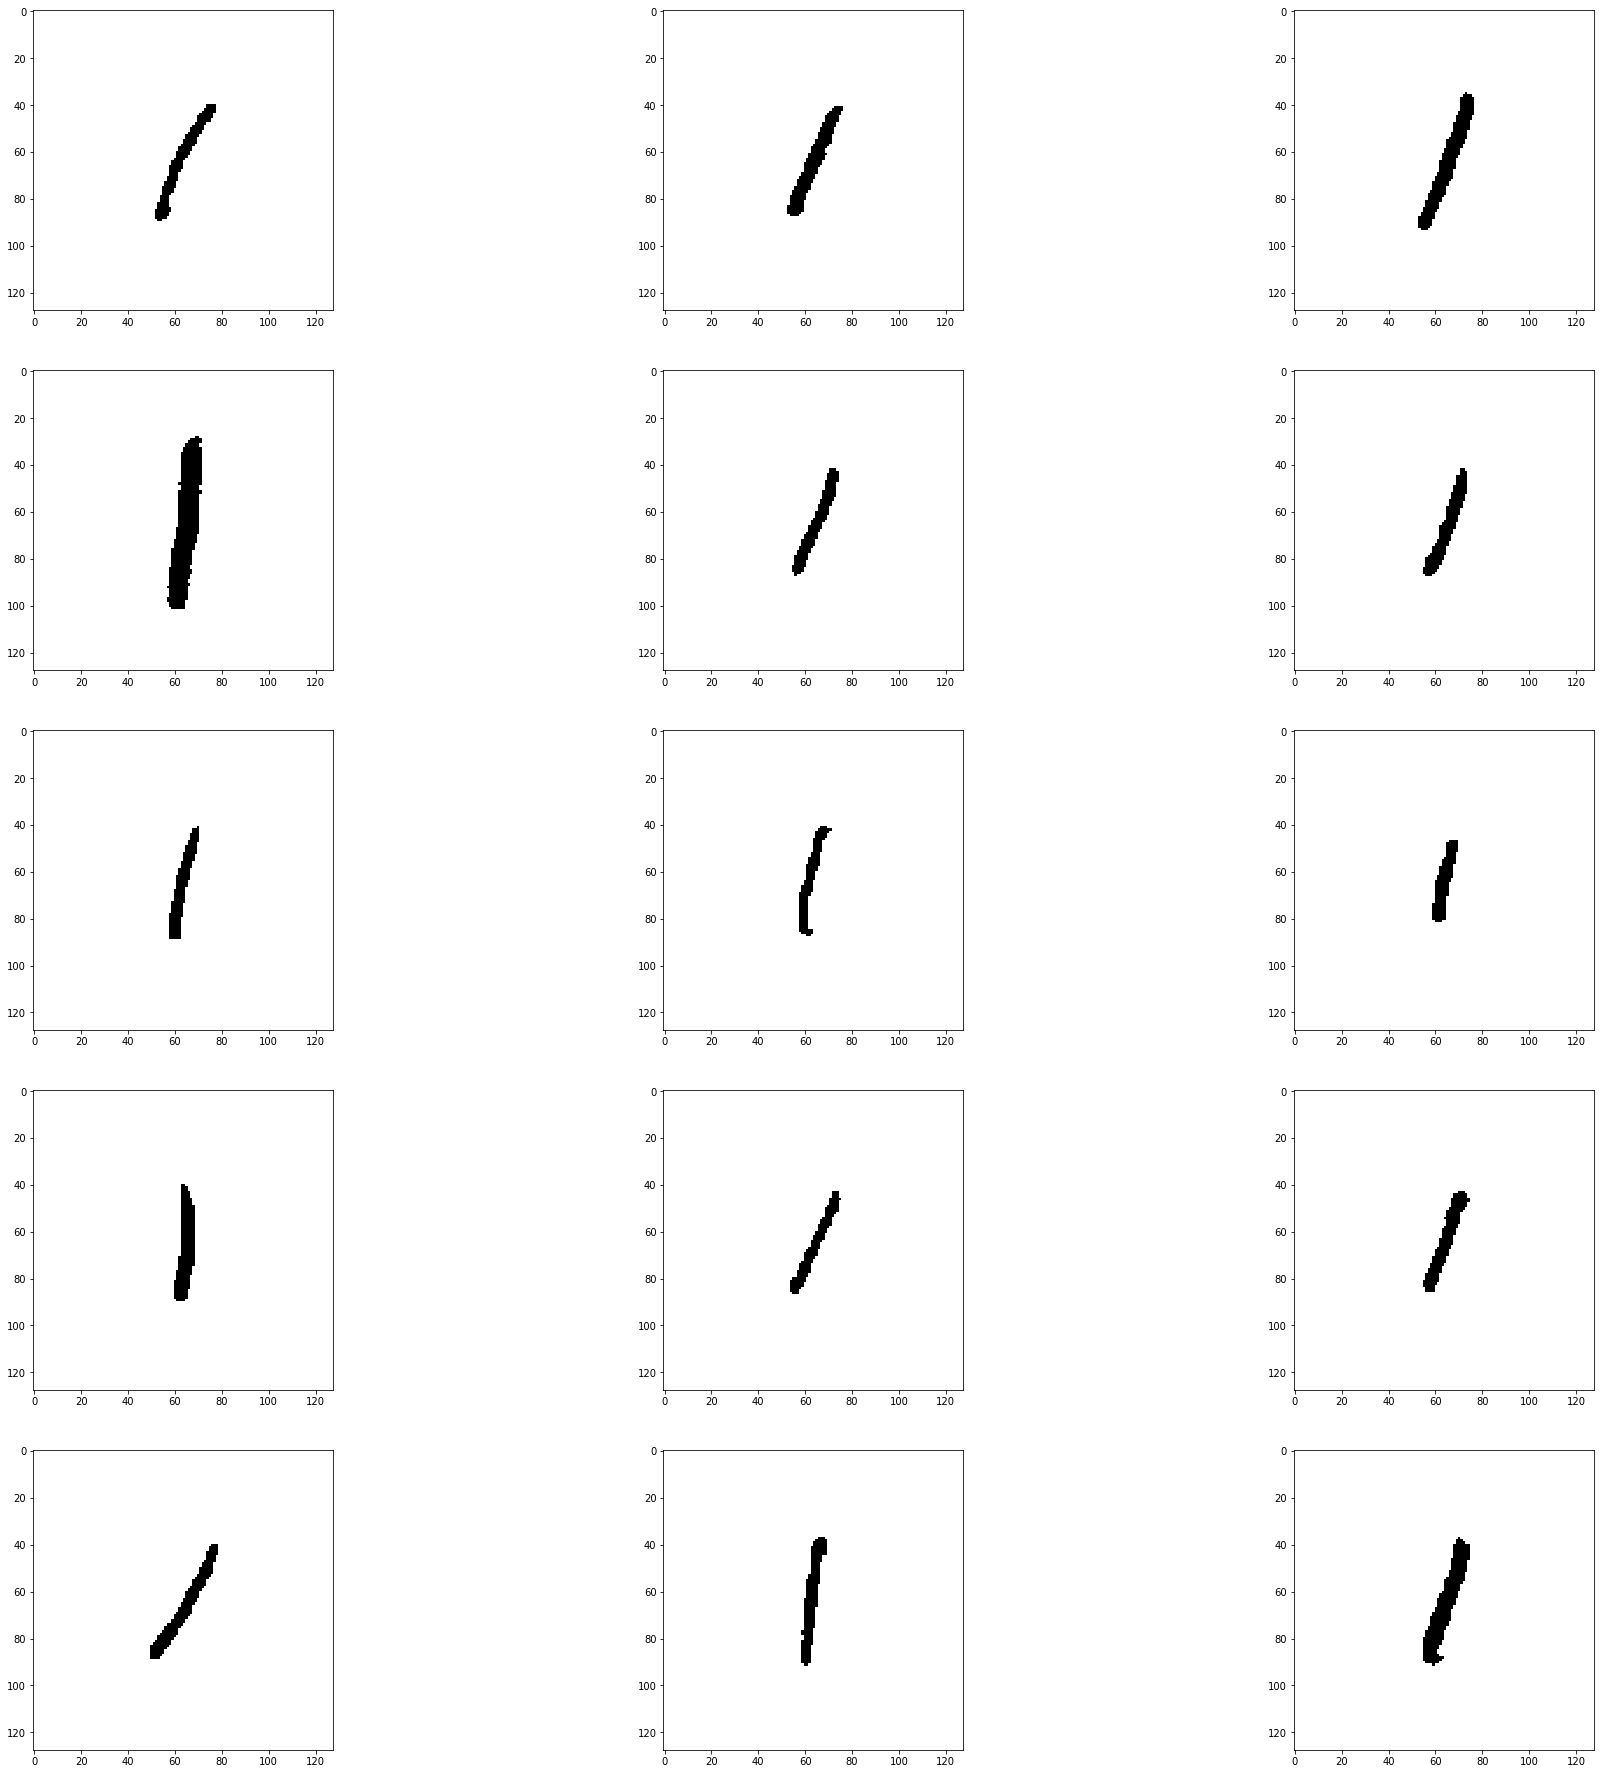

In [32]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(32, 32))
columns = 3 
rows = 5 
for i in range(1,rows*columns+1):
    IMG_PATH=BASE_PATH+'train_images/'
    img=Image.open(os.path.join(IMG_PATH,train_dataset.iloc[i][1]+'.png'))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## ****Importing and Installing Libraries****

In [33]:
!pip install efficientnet-pytorch
!pip install torchsummary
from torchsummary import summary

In [34]:
import PIL
import sys
import torch
from time import time
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

## **Data-Loader**

In [35]:
class Dataset(data.Dataset):
    def __init__(self,csv_path,images_path,transform=None):
        self.train_set=pd.read_csv(csv_path) 
        self.train_path=images_path
        self.transform=transform
        
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set.iloc[idx][1]+'.png'
        label=self.train_set.iloc[idx][2]
        img=Image.open(os.path.join(self.train_path,file_name)) 
        if self.transform is not None:
            img=self.transform(img)
        return img,label

## **Defining Transforms and Parameters for Training**

In [36]:
#Parameters
params = {'batch_size': 16,
          'shuffle': True
         }
epochs = 18
learning_rate=1e-3

In [37]:
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip()],0.7),
		transforms.ToTensor()])

In [38]:
training_set=Dataset(os.path.join(BASE_PATH,'train.csv'),os.path.join(BASE_PATH,'train_images/'),transform=transform_train)
training_generator=data.DataLoader(training_set,**params)

In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## **Importing the Model (Efficient Net)**

In [40]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=62)

Loaded pretrained weights for efficientnet-b0


In [41]:
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [42]:
print(summary(model, input_size=(3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 513, 513]               0
Conv2dStaticSamePadding-2         [-1, 32, 256, 256]             864
       BatchNorm2d-3         [-1, 32, 256, 256]              64
MemoryEfficientSwish-4         [-1, 32, 256, 256]               0
         ZeroPad2d-5         [-1, 32, 258, 258]               0
Conv2dStaticSamePadding-6         [-1, 32, 256, 256]             288
       BatchNorm2d-7         [-1, 32, 256, 256]              64
MemoryEfficientSwish-8         [-1, 32, 256, 256]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [43]:
PATH_SAVE='./Weights/'
if(not os.path.exists(PATH_SAVE)):
    os.mkdir(PATH_SAVE)

In [44]:
criterion = nn.CrossEntropyLoss()
lr_decay=0.99
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# **Training The Model**

In [45]:
eye = torch.eye(62).to(device)
classes=[i for i in range(62)]

In [46]:
history_accuracy=[]
history_loss=[]
epochs = 18

In [47]:
for epoch in range(epochs):
    running_loss = 0.0
    correct=0
    total=0
    class_correct = list(0. for _ in classes)
    class_total = list(0. for _ in classes)
    for i, data in enumerate(training_generator, 0):
        inputs, labels = data
        t0 = time()
        inputs, labels = inputs.to(device), labels.to(device)
        labels = eye[labels]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        c = (predicted == labels.data).squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = float(correct) / float(total)
        
        history_accuracy.append(accuracy)
        history_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        for j in range(labels.size(0)):
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        
        running_loss += loss.item()
        if(i%50==49):
            print( "Epoch : ",epoch+1," Batch : ", i+1," Loss :  ",running_loss/(i+1)," Accuracy : ",accuracy,"Time ",round(time()-t0, 2),"s" )
    for k in range(len(classes)):
        if(class_total[k]!=0):
            print('Accuracy of %5s : %2d %%' % (classes[k], 100 * class_correct[k] / class_total[k]))
        
    print('[%d epoch] Accuracy of the network on the Training images: %d %%' % (epoch+1, 100 * correct / total))
        
    torch.save(model.state_dict(), os.path.join(PATH_SAVE,str(epoch+1)+'.pth'))
        
torch.save(model.state_dict(), os.path.join(PATH_SAVE,'FINAL_EPOCH'+'.pth'))

Epoch :  1  Batch :  50  Loss :   3.439736928939819  Accuracy :  0.17 Time  0.09 s
Epoch :  1  Batch :  100  Loss :   2.6924143266677856  Accuracy :  0.310625 Time  0.1 s
Epoch :  1  Batch :  150  Loss :   2.2511788670221966  Accuracy :  0.39666666666666667 Time  0.09 s
Epoch :  1  Batch :  200  Loss :   1.9686623007059096  Accuracy :  0.45625 Time  0.09 s
Epoch :  1  Batch :  250  Loss :   1.798134348154068  Accuracy :  0.4885 Time  0.09 s
Epoch :  1  Batch :  300  Loss :   1.650209134320418  Accuracy :  0.523125 Time  0.11 s
Epoch :  1  Batch :  350  Loss :   1.5277196447338377  Accuracy :  0.5519642857142857 Time  0.09 s
Epoch :  1  Batch :  400  Loss :   1.4330515195429325  Accuracy :  0.57421875 Time  0.09 s
Epoch :  1  Batch :  450  Loss :   1.356212518480089  Accuracy :  0.5919444444444445 Time  0.09 s
Epoch :  1  Batch :  500  Loss :   1.2948580125570297  Accuracy :  0.6055 Time  0.09 s
Epoch :  1  Batch :  550  Loss :   1.2393380120938475  Accuracy :  0.6188636363636364 Time  

Epoch :  2  Batch :  1700  Loss :   0.39407436811748675  Accuracy :  0.8440441176470588 Time  0.09 s
Epoch :  2  Batch :  1750  Loss :   0.3942440291047096  Accuracy :  0.8438214285714286 Time  0.09 s
Epoch :  2  Batch :  1800  Loss :   0.39511084386044076  Accuracy :  0.8439930555555556 Time  0.09 s
Epoch :  2  Batch :  1850  Loss :   0.3950813146861824  Accuracy :  0.8439527027027027 Time  0.09 s
Accuracy of     0 : 54 %
Accuracy of     1 : 61 %
Accuracy of     2 : 84 %
Accuracy of     3 : 94 %
Accuracy of     4 : 93 %
Accuracy of     5 : 93 %
Accuracy of     6 : 91 %
Accuracy of     7 : 96 %
Accuracy of     8 : 94 %
Accuracy of     9 : 90 %
Accuracy of    10 : 94 %
Accuracy of    11 : 91 %
Accuracy of    12 : 75 %
Accuracy of    13 : 87 %
Accuracy of    14 : 89 %
Accuracy of    15 : 94 %
Accuracy of    16 : 95 %
Accuracy of    17 : 94 %
Accuracy of    18 : 97 %
Accuracy of    19 : 96 %
Accuracy of    20 : 73 %
Accuracy of    21 : 99 %
Accuracy of    22 : 95 %
Accuracy of    23 : 96 

Epoch :  4  Batch :  600  Loss :   0.31234617307782175  Accuracy :  0.8748958333333333 Time  0.09 s
Epoch :  4  Batch :  650  Loss :   0.3143459295997253  Accuracy :  0.874423076923077 Time  0.09 s
Epoch :  4  Batch :  700  Loss :   0.31255802407860755  Accuracy :  0.8754464285714286 Time  0.09 s
Epoch :  4  Batch :  750  Loss :   0.3116432680288951  Accuracy :  0.8755 Time  0.09 s
Epoch :  4  Batch :  800  Loss :   0.3084970297850668  Accuracy :  0.875390625 Time  0.09 s
Epoch :  4  Batch :  850  Loss :   0.30607299126246396  Accuracy :  0.8766911764705883 Time  0.09 s
Epoch :  4  Batch :  900  Loss :   0.30546734487016997  Accuracy :  0.8765277777777778 Time  0.09 s
Epoch :  4  Batch :  950  Loss :   0.3061465007223581  Accuracy :  0.8761842105263158 Time  0.09 s
Epoch :  4  Batch :  1000  Loss :   0.30790717448294164  Accuracy :  0.875375 Time  0.09 s
Epoch :  4  Batch :  1050  Loss :   0.307978118956089  Accuracy :  0.8748809523809524 Time  0.11 s
Epoch :  4  Batch :  1100  Loss : 

Epoch :  6  Batch :  50  Loss :   0.260071736574173  Accuracy :  0.88875 Time  0.09 s
Epoch :  6  Batch :  100  Loss :   0.26425350427627564  Accuracy :  0.8875 Time  0.09 s
Epoch :  6  Batch :  150  Loss :   0.26675413171450296  Accuracy :  0.89125 Time  0.09 s
Epoch :  6  Batch :  200  Loss :   0.26599874258041384  Accuracy :  0.889375 Time  0.09 s
Epoch :  6  Batch :  250  Loss :   0.28070183312892916  Accuracy :  0.8855 Time  0.09 s
Epoch :  6  Batch :  300  Loss :   0.27785718520482383  Accuracy :  0.886875 Time  0.09 s
Epoch :  6  Batch :  350  Loss :   0.26946379218782696  Accuracy :  0.8896428571428572 Time  0.09 s
Epoch :  6  Batch :  400  Loss :   0.267003882676363  Accuracy :  0.88875 Time  0.09 s
Epoch :  6  Batch :  450  Loss :   0.26316511730353037  Accuracy :  0.8906944444444445 Time  0.09 s
Epoch :  6  Batch :  500  Loss :   0.2637500759959221  Accuracy :  0.890375 Time  0.09 s
Epoch :  6  Batch :  550  Loss :   0.2650604022632946  Accuracy :  0.8889772727272728 Time  0

Epoch :  7  Batch :  1650  Loss :   0.26147774105722255  Accuracy :  0.8875757575757576 Time  0.09 s
Epoch :  7  Batch :  1700  Loss :   0.26138488995678283  Accuracy :  0.8877941176470588 Time  0.09 s
Epoch :  7  Batch :  1750  Loss :   0.2612600268125534  Accuracy :  0.8879285714285714 Time  0.09 s
Epoch :  7  Batch :  1800  Loss :   0.261152284923527  Accuracy :  0.8881597222222222 Time  0.09 s
Epoch :  7  Batch :  1850  Loss :   0.2608674893346993  Accuracy :  0.8881418918918919 Time  0.09 s
Accuracy of     0 : 58 %
Accuracy of     1 : 61 %
Accuracy of     2 : 91 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 96 %
Accuracy of     6 : 96 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 94 %
Accuracy of    10 : 97 %
Accuracy of    11 : 96 %
Accuracy of    12 : 88 %
Accuracy of    13 : 94 %
Accuracy of    14 : 96 %
Accuracy of    15 : 97 %
Accuracy of    16 : 97 %
Accuracy of    17 : 96 %
Accuracy of    18 : 99 %
Accuracy of    19 : 98 %

Epoch :  9  Batch :  550  Loss :   0.2236461349508979  Accuracy :  0.9018181818181819 Time  0.09 s
Epoch :  9  Batch :  600  Loss :   0.22201303482055665  Accuracy :  0.9025 Time  0.09 s
Epoch :  9  Batch :  650  Loss :   0.22063247121297397  Accuracy :  0.901826923076923 Time  0.09 s
Epoch :  9  Batch :  700  Loss :   0.22409921250173023  Accuracy :  0.9008928571428572 Time  0.09 s
Epoch :  9  Batch :  750  Loss :   0.22612714449564617  Accuracy :  0.90025 Time  0.09 s
Epoch :  9  Batch :  800  Loss :   0.22796004775911569  Accuracy :  0.899921875 Time  0.09 s
Epoch :  9  Batch :  850  Loss :   0.22728108072982114  Accuracy :  0.9002941176470588 Time  0.09 s
Epoch :  9  Batch :  900  Loss :   0.22677443659967847  Accuracy :  0.9003472222222222 Time  0.09 s
Epoch :  9  Batch :  950  Loss :   0.22831835597753525  Accuracy :  0.9 Time  0.09 s
Epoch :  9  Batch :  1000  Loss :   0.23172337175905705  Accuracy :  0.898 Time  0.12 s
Epoch :  9  Batch :  1050  Loss :   0.23353397522653851  Ac

Epoch :  11  Batch :  50  Loss :   0.22424812614917755  Accuracy :  0.89875 Time  0.09 s
Epoch :  11  Batch :  100  Loss :   0.23349096417427062  Accuracy :  0.8975 Time  0.09 s
Epoch :  11  Batch :  150  Loss :   0.22836672981580097  Accuracy :  0.8991666666666667 Time  0.09 s
Epoch :  11  Batch :  200  Loss :   0.22132426127791405  Accuracy :  0.901875 Time  0.09 s
Epoch :  11  Batch :  250  Loss :   0.22097621834278106  Accuracy :  0.9025 Time  0.09 s
Epoch :  11  Batch :  300  Loss :   0.2214740613102913  Accuracy :  0.901875 Time  0.09 s
Epoch :  11  Batch :  350  Loss :   0.2211172414251736  Accuracy :  0.9019642857142857 Time  0.09 s
Epoch :  11  Batch :  400  Loss :   0.21845412272959946  Accuracy :  0.90421875 Time  0.09 s
Epoch :  11  Batch :  450  Loss :   0.2148123546441396  Accuracy :  0.9066666666666666 Time  0.09 s
Epoch :  11  Batch :  500  Loss :   0.21623283153772355  Accuracy :  0.905625 Time  0.09 s
Epoch :  11  Batch :  550  Loss :   0.21864745616912842  Accuracy :

Epoch :  12  Batch :  1600  Loss :   0.21226401922293006  Accuracy :  0.9060546875 Time  0.09 s
Epoch :  12  Batch :  1650  Loss :   0.21248338133096695  Accuracy :  0.905719696969697 Time  0.09 s
Epoch :  12  Batch :  1700  Loss :   0.21222948729991914  Accuracy :  0.9061397058823529 Time  0.09 s
Epoch :  12  Batch :  1750  Loss :   0.21222469404765537  Accuracy :  0.906 Time  0.09 s
Epoch :  12  Batch :  1800  Loss :   0.21308057616154352  Accuracy :  0.9058333333333334 Time  0.09 s
Epoch :  12  Batch :  1850  Loss :   0.21354528470619305  Accuracy :  0.9053716216216217 Time  0.09 s
Accuracy of     0 : 57 %
Accuracy of     1 : 61 %
Accuracy of     2 : 95 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 96 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
Accuracy of    10 : 98 %
Accuracy of    11 : 98 %
Accuracy of    12 : 90 %
Accuracy of    13 : 95 %
Accuracy of    14 : 97 %
Accuracy of    15 : 98 %
Accuracy

Epoch :  14  Batch :  500  Loss :   0.19600188556313514  Accuracy :  0.917 Time  0.09 s
Epoch :  14  Batch :  550  Loss :   0.19626029141924597  Accuracy :  0.9164772727272728 Time  0.09 s
Epoch :  14  Batch :  600  Loss :   0.19982582482198874  Accuracy :  0.915 Time  0.09 s
Epoch :  14  Batch :  650  Loss :   0.20060464682487342  Accuracy :  0.9142307692307692 Time  0.09 s
Epoch :  14  Batch :  700  Loss :   0.20036204199705804  Accuracy :  0.9141071428571429 Time  0.09 s
Epoch :  14  Batch :  750  Loss :   0.2015761244893074  Accuracy :  0.9133333333333333 Time  0.09 s
Epoch :  14  Batch :  800  Loss :   0.20008817179128527  Accuracy :  0.91453125 Time  0.09 s
Epoch :  14  Batch :  850  Loss :   0.1995556676212479  Accuracy :  0.9143382352941176 Time  0.09 s
Epoch :  14  Batch :  900  Loss :   0.19749762791726325  Accuracy :  0.9146527777777778 Time  0.09 s
Epoch :  14  Batch :  950  Loss :   0.19741940484235163  Accuracy :  0.9145394736842105 Time  0.09 s
Epoch :  14  Batch :  1000

Epoch :  16  Batch :  50  Loss :   0.1896299397945404  Accuracy :  0.9125 Time  0.09 s
Epoch :  16  Batch :  100  Loss :   0.19364363104104995  Accuracy :  0.913125 Time  0.09 s
Epoch :  16  Batch :  150  Loss :   0.18896676580111185  Accuracy :  0.915 Time  0.09 s
Epoch :  16  Batch :  200  Loss :   0.18206215307116508  Accuracy :  0.918125 Time  0.09 s
Epoch :  16  Batch :  250  Loss :   0.1817080888748169  Accuracy :  0.91775 Time  0.09 s
Epoch :  16  Batch :  300  Loss :   0.1877403677503268  Accuracy :  0.9129166666666667 Time  0.09 s
Epoch :  16  Batch :  350  Loss :   0.18676408657005855  Accuracy :  0.9123214285714286 Time  0.09 s
Epoch :  16  Batch :  400  Loss :   0.1891061905771494  Accuracy :  0.9121875 Time  0.09 s
Epoch :  16  Batch :  450  Loss :   0.18822301818264855  Accuracy :  0.9133333333333333 Time  0.09 s
Epoch :  16  Batch :  500  Loss :   0.19209597778320311  Accuracy :  0.911125 Time  0.09 s
Epoch :  16  Batch :  550  Loss :   0.1953109878843481  Accuracy :  0.

Epoch :  17  Batch :  1600  Loss :   0.1928424434643239  Accuracy :  0.9133984375 Time  0.09 s
Epoch :  17  Batch :  1650  Loss :   0.1932593091599869  Accuracy :  0.9133712121212121 Time  0.1 s
Epoch :  17  Batch :  1700  Loss :   0.19309556188828805  Accuracy :  0.9133088235294118 Time  0.09 s
Epoch :  17  Batch :  1750  Loss :   0.19302839932271412  Accuracy :  0.9131785714285714 Time  0.09 s
Epoch :  17  Batch :  1800  Loss :   0.19284241187075774  Accuracy :  0.9134027777777778 Time  0.09 s
Epoch :  17  Batch :  1850  Loss :   0.19112095058769793  Accuracy :  0.9139527027027027 Time  0.09 s
Accuracy of     0 : 59 %
Accuracy of     1 : 65 %
Accuracy of     2 : 94 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %
Accuracy of    10 : 98 %
Accuracy of    11 : 98 %
Accuracy of    12 : 90 %
Accuracy of    13 : 96 %
Accuracy of    14 : 98 %
Accuracy of    15 : 98

## **Visualizing The Training Accuracy and losses**

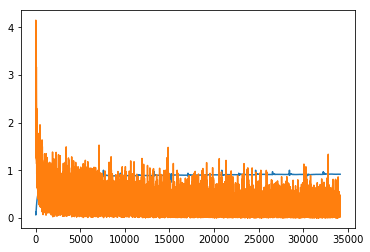

In [48]:
plt.plot(history_accuracy)
plt.plot(history_loss)

# **Inference**

In [49]:
model.load_state_dict(torch.load('/kaggle/working/Weights/FINAL_EPOCH.pth'))

<All keys matched successfully>

In [50]:
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [51]:
test_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                     ])

In [52]:
def predict_image(image):
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [53]:
submission=pd.read_csv(BASE_PATH+'sample_submission.csv')

In [54]:
submission.head(5)

,Unnamed: 0,filename,class
0,0,train_31_30009,0
1,1,train_31_29999,0
2,2,train_31_30029,0
3,3,train_31_30031,0
4,4,train_31_30019,0


In [55]:
IMG_TEST_PATH=os.path.join(BASE_PATH,'test_images/')
for i in range(len(submission)):
    img=Image.open(IMG_TEST_PATH+submission.iloc[i][1]+'.png')
    submission['class'][i]=predict_image(img)
    if(i%100==0 or i==len(submission)-1):
        print('[',32*'=','>] ',round((i+1)*100/len(submission),2),' % Complete')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[ ================================ >]  0.03  % Complete
[ ================================ >]  3.26  % Complete
[ ================================ >]  6.48  % Complete
[ ================================ >]  9.71  % Complete
[ ================================ >]  12.94  % Complete
[ ================================ >]  16.16  % Complete
[ ================================ >]  19.39  % Complete
[ ================================ >]  22.61  % Complete
[ ================================ >]  25.84  % Complete
[ ================================ >]  29.06  % Complete
[ ================================ >]  32.29  % Complete
[ ================================ >]  35.52  % Complete
[ ================================ >]  38.74  % Complete
[ ================================ >]  41.97  % Complete
[ ================================ >]  45.19  % Complete
[ ================================ >]  48.42  % Complete
[ ================================ >]  51.65  % Complete
[ ================================ 